In [2]:
# Importing the necessary libraries for AI2-THOR to run

!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab
import time
import math
from typing import Dict, List

from ai2thor.controller import Controller
from ai2thor_colab import (
    plot_frames,
    show_objects_table,
    side_by_side,
    overlay,
    show_video
)

# Class for controlling robot navigation. This is where we will have all the navigation commands.
# This has NOT yet got the LLM connected, but merely a set of tools to move the robot and to interact
# with the simulation environment.
class RobotNavigationControl:
    is_DEBUG = False

    # Starts server
    def start_ai2_thor(self):
        ai2thor_colab.start_xserver()
        "AI2-THOR Version: " + ai2thor.__version__

    # Initialises controller
    def initialise_controller(self):
        self.controller = Controller(
            agentMode="default",
            visibilityDistance=3,
            scene="FloorPlan209",
            # image modalities
            #renderDepthImage=False,
            #renderInstanceSegmentation=False,
            # camera properties
            width=400,
            height=400,
            fieldOfView=120,
            # step sizes
            gridSize=0.25,
            snapToGrid=True,
            #rotateStepDegrees=15,
        )

        # If debug is enabled, then print scene name and a few other things.
        if (self.is_DEBUG):
            event = self.controller.step(action="RotateRight")
            metadata = event.metadata
            print(event, event.metadata.keys())
            print("sceneName : " + self.controller.last_event.metadata["sceneName"])
            print("agent_pos : " + str(self.controller.last_event.metadata["agent"]["position"]))
            print("agent_rtn : " + str(self.controller.last_event.metadata["agent"]["rotation"]))
            #print("actionReturn : " + controller.last_event.metadata["actionReturn"])


        event = self.controller.step(
            action="AddThirdPartyCamera",
            position=dict(x=-4.25, y=2, z=-2.5),
            rotation=dict(x=90, y=0, z=0),
            fieldOfView=120
        )
            
    # Purely for debug - shows where the robot is, where the target is and the list of available positions
    # that can be navigated to.
    def print_world_state(self, target_name):
        obj_navigate_to = self.validate_object_in_collection(target_name, self.get_visible_objects())
        
        print("target pos : " + str(obj_navigate_to['position']))
        print("agent pos : " + str(self.controller.last_event.metadata["agent"]["position"]))
        
        #reachable_positions = self.controller.step(action="GetReachablePositions").metadata["actionReturn"]
        #print("reachable cells : " + str(reachable_positions))
        rc = self.get_reachable_cells_2d()
        print("reachable cells : " + str(rc))
            
    # Takes the list of available positions to navigate to, throws out the vertical dimension of each of them
    # (key: y) and creates a new list of these cells containing only 2d information.
    def get_reachable_cells_2d(self):
        reachable_positions = self.controller.step(action="GetReachablePositions").metadata["actionReturn"]
        
        positions_2d = []
        
        for pos in reachable_positions:
            positions_2d.append((pos["x"], pos["z"]))
            
        return positions_2d
        
    # Print a table of all objects in the scene
    def show_all_objects(self):
        show_objects_table(self.controller.last_event.metadata['objects'])
        print(self.controller.last_event.metadata['objects'])
    
    # Rotate left by given number of degrees degrees
    def rotate_left(self, deg):
        frames = []
        for _ in range(int(deg) // 5):
            frames.append(self.controller.step(action="RotateLeft", degrees=5).frame)
            time.sleep(0.05)
        
    # Rotate right by given number of degrees degrees
    def rotate_right(self, deg):
        frames = []
        for _ in range(int(deg) // 5):
            frames.append(self.controller.step(action="RotateRight", degrees=5).frame)
            time.sleep(0.05)
        
    # Rotate right or left depending on the degree (positive degree- right, negative - left)
    def rotate_by_degree(self, deg):
        if (deg < 0):
            self.rotate_left(abs(deg))
        else:
            self.rotate_right(abs(deg))
        
    # Store visible objects in the self.visible_objects collection and print them out if needed
    def get_visible_objects(self, print_objects = False):
        objects = self.controller.last_event.metadata['objects']
        visible_objects = []

        for obj in objects:
            if obj['visible']:
                if print_objects:
                    print(obj['objectType'] + " : " + str(obj['position']))
                visible_objects.append(obj)
                
        return visible_objects
        
    # Find the closest positon from the given reachable positions to the given object position using
    # Pythagorean theorem.
    def closest_position(self, object_position: Dict[str, float], reachable_positions: List[Dict[str, float]]) -> Dict[str, float]:
        out = reachable_positions[0]
        min_distance = float('inf')
        for pos in reachable_positions:
            # NOTE: y is the vertical direction, so only care about the x/z ground positions
            dist = sum([(pos[key] - object_position[key]) ** 2 for key in ["x", "z"]])
            if dist < min_distance:
                min_distance = dist
                out = pos
        return out

    # Finds the given object name in the given collection of objects and if found, returns the actual object
    def validate_object_in_collection(self, obj_name, obj_collection):        
        obj_names = sorted([obj["objectType"] for obj in obj_collection])
        
        try:
            assert obj_name in obj_names
        except AssertionError:
            print(obj_name + " is not visible!!!!!!!!!!!!!!!!")
            return None
        
        obj_of_interest = next(obj for obj in obj_collection if obj["objectType"] == obj_name)
        return obj_of_interest
    
    # Navigate to object defined by the name in the input
    def navigate_to_object(self, obj_name):
        #plot_frames(self.controller.last_event)
        obj_navigate_to = self.validate_object_in_collection(obj_name, self.get_visible_objects())
        
        # Can't navigate to an unknown object
        if (obj_navigate_to is None):
            return
        
        reachable_positions = self.controller.step(action="GetReachablePositions").metadata["actionReturn"]
        
        pos_navigate_to = self.closest_position(obj_navigate_to['position'], reachable_positions)
        
        #print(pos_navigate_to)
        
        self.controller.step(action="Teleport", **pos_navigate_to)
        #plot_frames(self.controller.last_event)
        
    # Print pose of the object defined by the name in the input
    def print_pose_of_object(self, obj_name):
        obj_of_interest = self.validate_object_in_collection(obj_name, self.controller.last_event.metadata['objects'])
        
        # Unknown object
        if (obj_of_interest is None):
            return
        
        print("position of " + obj_name + " : " + str(obj_of_interest["position"]))
        print("rotation of " + obj_name + " : " + str(obj_of_interest["rotation"]))
        
    # Print current pose of robot
    def print_current_pose_of_robot(self):
        print("agent_pos : " + str(self.controller.last_event.metadata["agent"]["position"]))
        print("agent_rtn : " + str(self.controller.last_event.metadata["agent"]["rotation"]))
        
    # Calculate angle from the target that we need to rotate by to face the target
    def get_angle_offset_from_target(self, obj_name):
        obj_of_interest = self.validate_object_in_collection(obj_name, self.controller.last_event.metadata['objects'])
        
        # Unknown object
        if (obj_of_interest is None):
            return None
        
        robot_position = self.controller.last_event.metadata["agent"]["position"]
        
        # Using formula tg(alpha) = a/b to find relative angle from robot to object
        #tg_alpha = (robot_position["z"] - obj_of_interest["position"]["z"]) / (robot_position["x"] - obj_of_interest["position"]["x"])
        z_diff = (robot_position["z"] - obj_of_interest["position"]["z"])
        x_diff = (robot_position["x"] - obj_of_interest["position"]["x"])
        #print(math.degrees(math.atan2(z_diff, x_diff)))
        return math.degrees(math.atan2(z_diff, x_diff))
        
    # Rotate to face the selected target
    def rotate_to_face_target(self, obj_name):
        angle_to_target = self.get_angle_offset_from_target(obj_name)
        
        if (angle_to_target is None):
            print(obj_name + " not visibile")
            return
        
        current_robot_yaw = self.controller.last_event.metadata["agent"]["rotation"]["y"]
        
        self.rotate_by_degree(angle_to_target - current_robot_yaw)
        #print("rotating by: " + str(angle_to_target - current_robot_yaw) + " " + str(angle_to_target) + " " + str(current_robot_yaw))
        
    # Get ceiling camera image -- can try using this if you don't like the 3rd camera set up earlier.
    def get_ceiling_image(self):
        # puts the camera in the ceiling, then puts it back with the robot
        event = self.controller.step('ToggleMapView')
        self.controller.step('ToggleMapView')
        return event.frame
    

In [3]:
rnc = RobotNavigationControl()
rnc.start_ai2_thor()
rnc.initialise_controller()

ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Pen : {'x': -2.829010248184204,

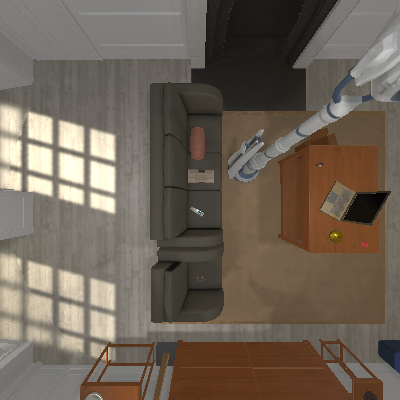

In [4]:
rnc.rotate_left(180)
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

In [5]:
rnc.print_world_state("Vase")

target pos : {'x': -2.6081905364990234, 'y': 0.579205334186554, 'z': -2.9408369064331055}
agent pos : {'x': -3.5, 'y': 0.9027014970779419, 'z': -2.0}
reachable cells : [(-3.5, -2.0), (-3.25, -2.0), (-3.5, -1.75), (-3.5, -2.25), (-3.25, -1.75), (-3.25, -2.25), (-3.5, -1.5), (-3.5, -2.5), (-3.25, -1.5), (-3.25, -2.5), (-3.5, -1.25), (-3.5, -2.75), (-3.0, -1.5), (-3.25, -1.25), (-3.25, -2.75), (-3.5, -1.0), (-3.5, -3.0), (-3.0, -1.25), (-3.25, -1.0), (-3.25, -3.0), (-3.5, -0.75), (-3.5, -3.25), (-2.75, -1.25), (-3.0, -1.0), (-3.25, -0.75), (-3.25, -3.25), (-3.75, -0.75), (-3.5, -3.5), (-2.5, -1.25), (-2.75, -1.0), (-3.0, -0.75), (-3.25, -3.5), (-4.0, -0.75), (-3.5, -3.75), (-2.5, -1.0), (-2.75, -0.75), (-3.0, -3.5), (-3.25, -3.75), (-4.25, -0.75), (-3.5, -4.0), (-2.25, -1.0), (-2.5, -0.75), (-2.75, -3.5), (-3.0, -3.75), (-3.25, -4.0), (-4.5, -0.75), (-3.5, -4.25), (-2.0, -1.0), (-2.25, -0.75), (-2.5, -3.5), (-2.75, -3.75), (-3.0, -4.0), (-3.25, -4.25), (-4.75, -0.75), (-3.75, -4.25), (-3.

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': -0.0, 'y': 180.00001525878906, 'z': 0.0}
-79.0493526032736
Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777

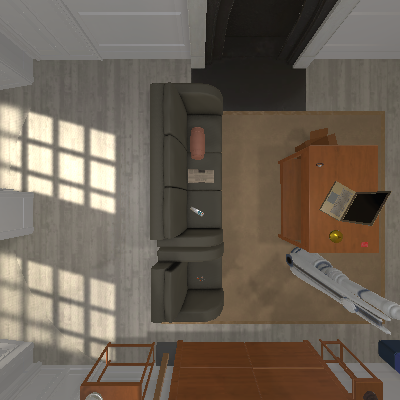

In [6]:
rnc.navigate_to_object("Vase")
rnc.print_current_pose_of_robot()
print(rnc.get_angle_offset_from_target("Vase"))
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': 0.0, 'y': 285.0000305175781, 'z': 0.0}
ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Newspaper : {'x': -4.237964630126953, 'y': 0.3441956341266632, 'z': -2.164184093475342}
Pillow : {'x': -4.282398700714111, 'y': 0.42073073983192444, 'z': -1.7359906435012817}
RemoteControl : {'x': -4.292991638183594, 'y': 0.33039507269859314, 'z': -2.6639568805694

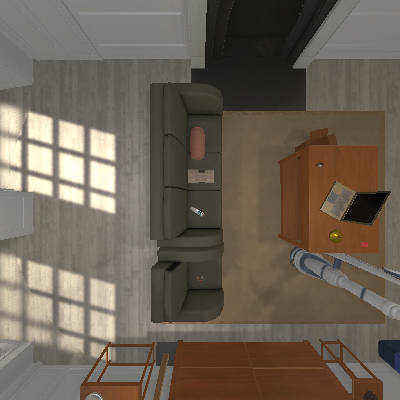

In [7]:
rnc.rotate_to_face_target("Vase")
rnc.print_current_pose_of_robot()
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777442932129}
Pen : {'x': -2.829010248184204, 'y': 0.7048501372337341, 'z': -4.962978363037109}
Shelf : {'x': -2.475966215133667, '

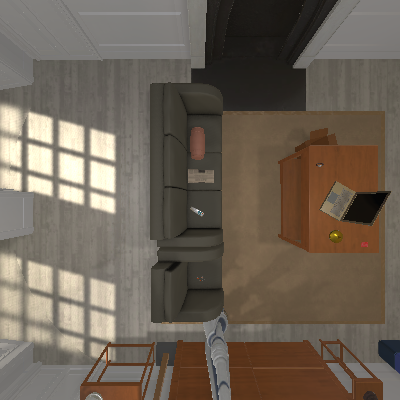

In [8]:
#aa = rnc.get_visible_objects(True)
rnc.navigate_to_object("Drawer")
rnc.rotate_to_face_target("Drawer")
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])